## Introduction
Erwin de Leon and Joeseph Schilling introduce their April 2017 Urban Instute research report ["Urban Blight and Public Health: Addressing the Impact of Substandard Housing, Abandoned Buildings, and Vacant Lots"](https://www.urban.org/research/publication/urban-blight-and-public-health) with the following statement: "We spend more than 2/3rds of our time where we live; thus, housing and neighborhood conditions affect our individual and family's well-being". They also discuss the impact of poor economic conditions that result in "increasing inventories of vacant homes and abandoned buildings". For example, the authors of this report cite Detroit's Blight Removal Task Force's 2014 "strategic plan to address more than 80,000 derelict structures and vacant lots".

This Jupyter notebook illustrates the application of the Python programming language to address three questions regarding the [City of Detroit's Blight Violation Notices (BVN) public domain dataset](https://data.detroitmi.gov/Property-Parcels/Blight-Violations/ti6p-wcg4):  
1. Is the number of blight violations per month increasing, decreasing, or staying constant over time?  
2. Is the number of blight violations in collection increasing, decreasing, or staying constant over time?  
3. For 2017, are blight violation notices clustered as a function of latitute and longitude?  

## Import Dependencies

In [1]:
import numpy as np
import pandas as pd
import os
import urllib
import re
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from datetime import datetime

%load_ext pycodestyle_magic
%matplotlib inline

## Prepare Data  
-[Download *.csv from URL](https://stackoverflow.com/questions/41992223/download-csv-from-web-service-with-python-3)  
-[Verify PEP8 in IPython notebook](https://stackoverflow.com/questions/26126853/verifying-pep8-in-ipython-notebook-code)  
-[Tidy Data](https://www.jstatsoft.org/article/view/v059i10)  
-[Rename DataFrame columns](https://chrisalbon.com/python/data_wrangling/pandas_rename_multiple_columns/)  

In [73]:
def read_bvn_csvfile(bvn_csvfile):
    """
    
    """
    df = pd.read_csv(bvn_csvfile, low_memory=False)
    
    print("(# of rows, # of columns): (%d, %d)" % (df.shape[0], df.shape[1]))

    # Transform column names to "tidy data format"
    # https://www.jstatsoft.org/article/view/v059i10
    df.columns = [re.sub("[\s\(\)-]", '', elem).lower() for elem in df.columns]

    # Combine violationdate & ticketissuedtime
    df['violationdatetime'] = df['violationdate'] + ' ' + df['ticketissuedtime']

    # Filter invalid timestamp
    pattern_obj = re.compile('[0-9]+/[0-9]+/[0-9]+ [0-9]+:[0-9]+:[0-9]+')

    h_pattern = lambda elem: pattern_obj.match(elem) != None

    is_valid_datetime = df['violationdatetime'].apply(h_pattern)

    percentage_valid_datetime = is_valid_datetime.sum() * (100 / df.shape[0])

    print("Percentage of valid date/time: %.2f" % (percentage_valid_datetime))

    df = df[is_valid_datetime]

    # Convert timestamp from string to datetime object
    h_convert = lambda elem: datetime.strptime(elem, '%m/%d/%Y %H:%M:%S')

    df['violationdatetime'] = df['violationdatetime'].apply(h_convert)

    # violationlocation - contains duplicate information
    columns_to_filter = ['violationdate',
                         'ticketissuedtime',
                         'violationlocation']

    df = df.filter([elem for elem in df.columns if elem not in columns_to_filter])

    return df

def compute_violationdatetime_histogram(df):
    """
    """
    violationdatetime_histogram =\
        df['violationdatetime'].apply(lambda elem: elem.year).value_counts()

    violationdatetime_histogram = list(zip(violationdatetime_histogram.index,
                                           violationdatetime_histogram.values))

    violationdatetime_histogram_df = pd.DataFrame(violationdatetime_histogram,
                                                  columns=['year', 'count'])

    return violationdatetime_histogram_df.sort_values('year')

def filter_outlier_violationdatetime(df,
                                     minimum_year_count=10000):
    """
    """
    filter_data = violationdatetime_histogram_df['count'] < minimum_year_count
    years_to_filter = violationdatetime_histogram_df[filter_data]['year'].values

    h_select_data = lambda elem: elem.year not in years_to_filter

    select_data = df['violationdatetime'].apply(h_select_data)

    percent_filtered = 100 * (1 - select_data.sum() / df.shape[0])

    print("Percentage of data filtered: %.2e %%" % (percent_filtered))

    filtered_df = df.copy()

    return filtered_df[select_data]

def evaluate_percenage_missingrows(df):
    """
    """
    missing_rows = df.isnull().sum(axis=0)
    missing_rows = missing_rows[missing_rows > 0]
    missing_rows = missing_rows.sort_values(ascending=False)
    missing_rows = list(zip(missing_rows.index, missing_rows.values))

    missing_rows_df = pd.DataFrame(missing_rows, columns=['column', 'count'])

    missing_rows_df['percentmissing'] = missing_rows_df['count'] * (100 / df.shape[0])
    
    return missing_rows_df

def filter_missing_rows(df,
                        missing_rows_df,
                        percentmissing_threshold=5):
    """
    """
    filter_data = missing_rows_df['percentmissing'] > percentmissing_threshold

    columns_to_keep = [elem for elem in df.columns if elem not in
                       missing_rows_df[filter_data]['column'].values]

    return df.filter(columns_to_keep)

def evaluate_percentage_missingcolumns(df):
    """
    """
    missing_columns = df.isnull().sum(axis=1).value_counts()

    missing_columns = list(zip(missing_columns.index, missing_columns.values))

    missing_columns_df = pd.DataFrame(missing_columns,
                                      columns=['missingcolumns', 'count'])

    missing_columns_df['percentmissing'] =\
        missing_columns_df['missingcolumns'] * (100 / df.shape[1])

    return missing_columns_df

def filter_missing_columns(df,
                           missing_columns_df,
                           percentmissing_threshold=5):
    """
    """
    filter_data =\
        missing_columns_df['percentmissing'] > percentmissing_threshold

    missingcols_threshold =\
        missing_columns_df[filter_data]['missingcolumns'].min()

    return df[df.isnull().sum(axis=1) < missingcols_threshold]

In [3]:
#%%pycodestyle
csv_url = "https://data.detroitmi.gov/api/views/ti6p-wcg4" +\
          "/rows.csv?accessType=DOWNLOAD"

data_dir = './Data'
csv_file = os.path.join(data_dir, 'rows.csv')

if not os.path.exists(data_dir):
    os.mkdir(data_dir)
    urllib.request.urlretrieve(csv_url, csv_file)

### Load Blight Violation Notices Data

In [20]:
bvn_df = read_bvn_csvfile(csv_file)

(# of rows, # of columns): (392050, 40)
Percentage of valid date/time: 99.98


### Filter Outlier Timestamps
-[Rotate axis text in Python](https://stackoverflow.com/questions/10998621/rotate-axis-text-in-python-matplotlib)  

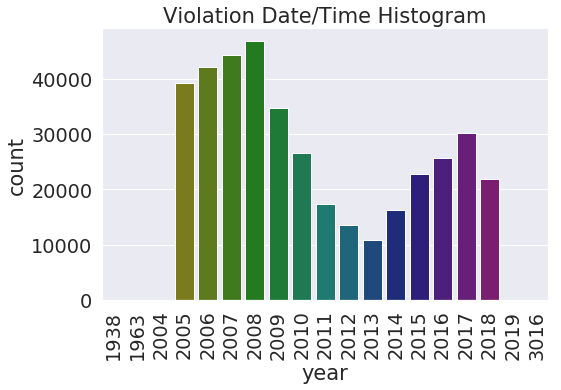

In [21]:
violationdatetime_histogram_df = compute_violationdatetime_histogram(bvn_df)

palette = sns.hls_palette(violationdatetime_histogram_df.shape[0], l=.3, s=.8)

sns.set(font_scale=1.75)
plt.figure(figsize=(8, 5))
sns.barplot(x='year',
            y='count',
            data=violationdatetime_histogram_df,
            palette=palette)
plt.xticks(rotation=90);
plt.title('Violation Date/Time Histogram');

In [22]:
bvn_df = filter_outlier_violationdatetime(bvn_df)

Percentage of data filtered: 7.65e-03 %


### Filter Columns With A High Percentage of Missing Data
-[Yiran Dong and Chao-Ying Joanne Peng "Principled missing data methods for researchers"](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3701793/)

In [24]:
missing_rows_df = evaluate_percenage_missingrows(bvn_df)

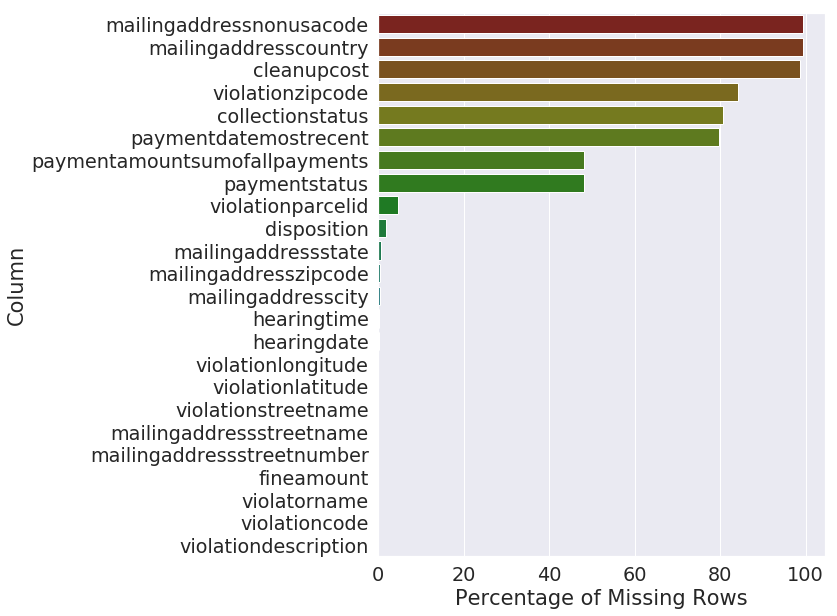

In [67]:
palette = sns.hls_palette(missing_rows_df.shape[0], l=.3, s=.8)

sns.set(font_scale=1.75)
plt.figure(figsize=(8, 10))
sns.barplot(x='percentmissing',
            y='column',
            data=missing_rows_df,
            palette=palette)
plt.xlabel('Percentage of Missing Rows')
plt.ylabel('Column');

In [30]:
bvn_df = filter_missing_rows(bvn_df,
                             missing_rows_df)

## Remove columns with a large amount of missing data  

In [52]:
missing_columns_df = evaluate_percentage_missingcolumns(bvn_df)

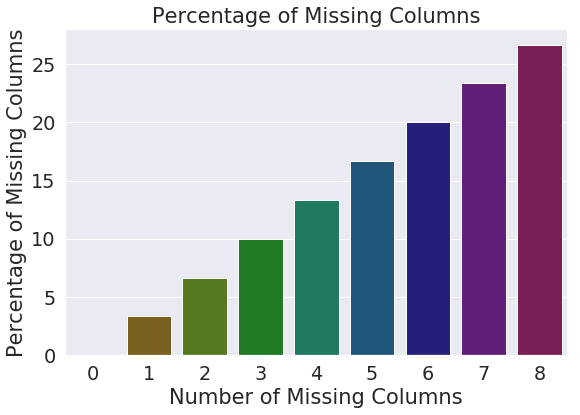

In [64]:
palette = sns.hls_palette(missing_columns_df.shape[0], l=.3, s=.8)

sns.set(font_scale=1.75)
plt.figure(figsize=(9, 6))
sns.barplot(x='missingcolumns',
            y='percentmissing',
            data=missing_columns_df,
            palette=palette)
plt.xlabel('Number of Missing Columns')
plt.ylabel('Percentage of Missing Columns')
plt.title('Percentage of Missing Columns');

In [74]:
bvn_df = filter_missing_columns(bvn_df,
                                missing_columns_df)

In [75]:
evaluate_percentage_missingcolumns(bvn_df)

,missingcolumns,count,percentmissing
0,0,365149,0.000000
1,1,23855,3.333333
